In [33]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from skimage.feature import hog
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
from collections import OrderedDict
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from skimage.feature import hog
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [34]:
class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_relu(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_relu(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_relu(256, 384, 3, pad=1)),
            ('conv4', conv_bn_relu(384, 384, 3, pad=1)),
            ('conv5', conv_bn_relu(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_relu(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_relu(self.feature_space_size, self.feature_space_size)),
        ]))

    def forward(self, inputs):
        x = self.conv_layers(inputs)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x

def conv_bn_relu(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.ReLU()),
    ]))


def linear_bn_relu(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.ReLU()),
    ]))

In [35]:

# Load the checkpoint
checkpoint = torch.load('sigver/models/signet.pth')

# Check what's inside the checkpoint
print("Checkpoint keys:", checkpoint.keys() if isinstance(checkpoint, dict) else type(checkpoint))

# The pretrained weights are likely stored with a specific key
# Try these different loading methods:

# Method 1: If checkpoint is a tuple (model, optimizer, etc.)
if isinstance(checkpoint, tuple):
    model = SigNet()
    model.load_state_dict(checkpoint[0])  # First element is usually state_dict
    model.eval()
    print("✓ Loaded pretrained SigNet model (from tuple)")

# Method 2: If checkpoint is a dict with 'model' or 'state_dict' key
elif isinstance(checkpoint, dict):
    model = SigNet()
    
    if 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    elif 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'])
    elif 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        # It's directly the state_dict
        model.load_state_dict(checkpoint)
    
    model.eval()
    print("✓ Loaded pretrained SigNet model (from dict)")

# Method 3: More robust loading
else:
    print(f"Unexpected checkpoint format: {type(checkpoint)}")


Checkpoint keys: <class 'tuple'>
✓ Loaded pretrained SigNet model (from tuple)


In [36]:
class EnhancedSigNetVerifier:
    """
    Improved SigNet with:
    - Better preprocessing (high-res, enhancement)
    - Multiple distance metrics
    - Adaptive threshold with outlier detection
    """
    def __init__(self, model, device='cuda'):
        self.model = model
        self.model.eval()
        self.model.to(device)
        self.device = device
        self.references = {}
        self.thresholds = {}
    
    def preprocess(self, img):
        """Enhanced preprocessing pipeline"""
        # Grayscale
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()
        
        # Upscale for better quality (if small)
        h, w = gray.shape
        if w < 600:
            scale = 600 / w
            gray = cv2.resize(gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        
        # Denoise
        gray = cv2.fastNlMeansDenoising(gray, None, h=8, templateWindowSize=7, searchWindowSize=21)
        
        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
        
        # Normalize
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
        
        # Resize to SigNet input (220x150)
        resized = cv2.resize(gray, (220, 150), interpolation=cv2.INTER_AREA)
        
        # Convert to tensor
        normalized = resized.astype(np.float32) / 255.0
        
        # Ensure dark signature on white
        if normalized.mean() < 0.5:
            normalized = 1.0 - normalized
        
        tensor = torch.FloatTensor(normalized).unsqueeze(0).unsqueeze(0)
        return tensor.to(self.device)
    
    def get_embedding(self, img):
        """Extract SigNet embedding"""
        with torch.no_grad():
            tensor = self.preprocess(img)
            embedding = self.model(tensor)
        return embedding
    
    def register(self, person_id, ref_images):
        """Register with outlier detection"""
        embeddings = [self.get_embedding(img) for img in ref_images]
        
        # Compute all pairwise distances
        n = len(embeddings)
        dist_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    dist = F.pairwise_distance(embeddings[i], embeddings[j]).item()
                    dist_matrix[i, j] = dist
        
        # Detect outliers (references that are far from others)
        mean_distances = dist_matrix.sum(axis=1) / (n - 1)
        threshold_outlier = mean_distances.mean() + 2 * mean_distances.std()
        
        # Remove outliers
        clean_indices = [i for i in range(n) if mean_distances[i] < threshold_outlier]
        
        if len(clean_indices) < n:
            print(f"Removed {n - len(clean_indices)} outlier reference(s)")
            embeddings = [embeddings[i] for i in clean_indices]
        
        # Compute intra-distances from clean references
        if len(embeddings) > 1:
            intra_dists = []
            for i in range(len(embeddings)):
                for j in range(i+1, len(embeddings)):
                    dist = F.pairwise_distance(embeddings[i], embeddings[j]).item()
                    intra_dists.append(dist)
            
            # Adaptive threshold using percentile (more robust)
            threshold = np.percentile(intra_dists, 90) * 1.5
            threshold = min(max(threshold, 1.5), 6.0)
        else:
            threshold = 4.0
        
        self.references[person_id] = embeddings
        self.thresholds[person_id] = threshold
        
        return threshold
    
    def verify(self, person_id, test_img):
        """Verify with multiple strategies"""
        test_emb = self.get_embedding(test_img)
        ref_embs = self.references[person_id]
        
        # Compute distances to all references
        distances = [F.pairwise_distance(ref, test_emb).item() for ref in ref_embs]
        
        # Use minimum distance (most similar reference)
        min_dist = min(distances)
        avg_dist = np.mean(distances)
        
        threshold = self.thresholds[person_id]
        
        # Decision
        is_genuine = min_dist < threshold
        
        # Confidence score (continuous for AUC)
        # Map distance to [0, 1] where 1 = perfect match, 0 = far away
        if min_dist < threshold:
            score = 1.0 - (min_dist / threshold)
        else:
            # Beyond threshold but provide gradient
            score = max(0, 1.0 - (min_dist / (threshold * 2)))
        
        return {
            'verified': is_genuine,
            'distance': min_dist,
            'score': float(score)
        }

In [37]:
class EnhancedHOGVerifier:
    """
    Improved HOG with:
    - High-resolution processing
    - Better HOG parameters
    - Multiple distance metrics
    - Outlier detection
    """
    def __init__(self):
        self.references = {}
        self.thresholds = {}
        
        # Optimized HOG parameters for signatures
        self.hog_params = {
            'orientations': 12,  # Increased from 9 (more gradient directions)
            'pixels_per_cell': (6, 6),  # Smaller cells (more detail)
            'cells_per_block': (3, 3),  # Larger blocks (more context)
            'visualize': False,
            'feature_vector': True,
            'transform_sqrt': True,  # Power law compression
            'block_norm': 'L2-Hys'  # Better normalization
        }
    
    def preprocess(self, img):
        """Enhanced preprocessing for HOG"""
        # Grayscale
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()
        
        # Upscale to high resolution
        h, w = gray.shape
        if w < 600:
            scale = 600 / w
            gray = cv2.resize(gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        
        # Denoise
        gray = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)
        
        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
        gray = clahe.apply(gray)
        
        # Sharpen (enhances edges for HOG)
        kernel = np.array([[-1,-1,-1],
                          [-1, 9,-1],
                          [-1,-1,-1]])
        gray = cv2.filter2D(gray, -1, kernel)
        
        # Resize to larger size for more HOG features
        resized = cv2.resize(gray, (400, 200), interpolation=cv2.INTER_AREA)
        
        # Normalize
        normalized = cv2.normalize(resized, None, 0, 255, cv2.NORM_MINMAX)
        
        # Extract HOG features
        features = hog(normalized, **self.hog_params)
        
        return features
    
    def register(self, person_id, ref_images):
        """Register with outlier detection"""
        features_list = [self.preprocess(img) for img in ref_images]
        
        # Compute pairwise distances
        n = len(features_list)
        dist_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    # Use both cosine and euclidean, take average
                    cos_dist = cosine(features_list[i], features_list[j])
                    euc_dist = euclidean(features_list[i], features_list[j]) / 1000  # Normalize
                    dist_matrix[i, j] = (cos_dist + euc_dist) / 2
        
        # Detect outliers
        mean_distances = dist_matrix.sum(axis=1) / (n - 1)
        threshold_outlier = mean_distances.mean() + 2 * mean_distances.std()
        
        clean_indices = [i for i in range(n) if mean_distances[i] < threshold_outlier]
        
        if len(clean_indices) < n:
            print(f" Removed {n - len(clean_indices)} outlier reference(s)")
            features_list = [features_list[i] for i in clean_indices]
        
        # Compute adaptive threshold
        if len(features_list) > 1:
            intra_dists = []
            for i in range(len(features_list)):
                for j in range(i+1, len(features_list)):
                    cos_dist = cosine(features_list[i], features_list[j])
                    intra_dists.append(cos_dist)
            
            # Use percentile for robustness
            threshold = np.percentile(intra_dists, 85) * 1.3
            threshold = min(max(threshold, 0.10), 0.45)
        else:
            threshold = 0.25
        
        self.references[person_id] = features_list
        self.thresholds[person_id] = threshold
        
        return threshold
    
    def verify(self, person_id, test_img):
        """Verify with improved scoring"""
        test_feat = self.preprocess(test_img)
        ref_feats = self.references[person_id]
        
        # Compute distances
        distances = [cosine(ref, test_feat) for ref in ref_feats]
        
        min_dist = min(distances)
        threshold = self.thresholds[person_id]
        
        # Decision
        is_genuine = min_dist < threshold
        
        # Improved confidence score
        if min_dist < threshold:
            score = 1.0 - (min_dist / threshold)
        else:
            score = max(0, 1.0 - (min_dist / (threshold * 2)))
        
        return {
            'verified': is_genuine,
            'distance': min_dist,
            'score': float(score)
        }


In [38]:
class EnsembleVerifier:
    """
    Combine SigNet and HOG for best performance
    """
    def __init__(self, signet_model, device='cuda'):
        self.signet_verifier = EnhancedSigNetVerifier(signet_model, device)
        self.hog_verifier = EnhancedHOGVerifier()
        self.references = {}
        self.weights = {'signet': 0.6, 'hog': 0.4}  # Adjust based on performance
    
    def register(self, person_id, ref_images):
        """Register with both models"""
        signet_thresh = self.signet_verifier.register(person_id, ref_images)
        hog_thresh = self.hog_verifier.register(person_id, ref_images)
        self.references[person_id] = True
        
        return {'signet': signet_thresh, 'hog': hog_thresh}
    
    def verify(self, person_id, test_img):
        """Ensemble verification"""
        signet_result = self.signet_verifier.verify(person_id, test_img)
        hog_result = self.hog_verifier.verify(person_id, test_img)
        
        # Weighted average of scores
        ensemble_score = (
            signet_result['score'] * self.weights['signet'] +
            hog_result['score'] * self.weights['hog']
        )
        
        # Decision based on ensemble score
        is_genuine = ensemble_score > 0.5
        
        return {
            'verified': is_genuine,
            'score': float(ensemble_score),
            'signet_score': signet_result['score'],
            'hog_score': hog_result['score'],
            'distance': {
                'signet': signet_result['distance'],
                'hog': hog_result['distance']
            }
        }


In [41]:
class ImprovedEvaluator:
    def __init__(self, signet_model=None):
        self.signet_model = signet_model
        self.results = []
    
    def load_images(self, person_folder, num_orig=7, num_fake=7):
        """Load images (assuming orig1-7.jpg and fake1-7.jpg naming)"""
        from pathlib import Path
        folder = Path(person_folder)
        
        orig_images = []
        for i in range(1, num_orig + 1):
            path = folder / f'orig{i}.jpg'
            if path.exists():
                orig_images.append(cv2.imread(str(path)))
        
        fake_images = []
        for i in range(1, num_fake + 1):
            path = folder / f'fake{i}.jpg'
            if path.exists():
                fake_images.append(cv2.imread(str(path)))
        
        return orig_images, fake_images
    
    def run_experiment(self, person_id, orig_images, fake_images, num_train=3, num_seeds=3):
        """Run evaluation with improved models"""
        print(f"\n{'='*70}")
        print(f"EVALUATING (IMPROVED MODELS): {person_id}")
        print(f"{'='*70}")
        
        all_results = {
            'signet': [],
            'hog': [],
            'ensemble': []
        }
        
        for seed in range(num_seeds):
            print(f"\n--- Seed {seed+1}/{num_seeds} ---")
            
            np.random.seed(seed)
            indices = list(range(len(orig_images)))
            np.random.shuffle(indices)
            
            train_indices = indices[:num_train]
            test_indices = indices[num_train:]
            
            train_images = [orig_images[i] for i in train_indices]
            test_genuine = [orig_images[i] for i in test_indices]
            
            print(f"  Train: {[i+1 for i in train_indices]}, Test genuine: {[i+1 for i in test_indices]}")
            
            # Test improved models
            if self.signet_model is not None:
                # Enhanced SigNet
                signet_v = EnhancedSigNetVerifier(self.signet_model)
                signet_v.register(person_id, train_images)
                signet_res = self._evaluate(signet_v, person_id, test_genuine, fake_images, 'SigNet++')
                all_results['signet'].append(signet_res)
                
                # Ensemble
                ensemble_v = EnsembleVerifier(self.signet_model)
                ensemble_v.register(person_id, train_images)
                ensemble_res = self._evaluate(ensemble_v, person_id, test_genuine, fake_images, 'Ensemble')
                all_results['ensemble'].append(ensemble_res)
            
            # Enhanced HOG
            hog_v = EnhancedHOGVerifier()
            hog_v.register(person_id, train_images)
            hog_res = self._evaluate(hog_v, person_id, test_genuine, fake_images, 'HOG++')
            all_results['hog'].append(hog_res)
        
        # Aggregate
        summary = self._aggregate(all_results, person_id)
        self.results.append(summary)
        
        return summary
    
    def _evaluate(self, verifier, person_id, test_genuine, test_forgery, model_name):
        """Evaluate single model"""
        y_true, y_scores = [], []
        
        for img in test_genuine:
            result = verifier.verify(person_id, img)
            y_true.append(1)
            y_scores.append(result['score'])
        
        for img in test_forgery:
            result = verifier.verify(person_id, img)
            y_true.append(0)
            y_scores.append(result['score'])
        
        # Metrics
        y_pred = [1 if s > 0.5 else 0 for s in y_scores]
        acc = accuracy_score(y_true, y_pred)
        
        try:
            auc = roc_auc_score(y_true, y_scores)
        except:
            auc = 0.5
        
        print(f"  {model_name}: Acc={acc:.2%}, AUC={auc:.3f}")
        
        return {'accuracy': acc, 'auc': auc}
    
    def _aggregate(self, all_results, person_id):
        """Aggregate results"""
        summary = {'person_id': person_id}
        
        for model in ['signet', 'hog', 'ensemble']:
            if all_results[model]:
                summary[f'{model}_acc_mean'] = np.mean([r['accuracy'] for r in all_results[model]])
                summary[f'{model}_acc_std'] = np.std([r['accuracy'] for r in all_results[model]])
                summary[f'{model}_auc_mean'] = np.mean([r['auc'] for r in all_results[model]])
                summary[f'{model}_auc_std'] = np.std([r['auc'] for r in all_results[model]])
        
        return summary
    
    def plot_comparison(self):
        """Plot improved results"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        persons = [r['person_id'] for r in self.results]
        x = np.arange(len(persons))
        width = 0.25
        
        # Accuracy
        ax = axes[0]
        signet_acc = [r.get('signet_acc_mean', 0) for r in self.results]
        hog_acc = [r.get('hog_acc_mean', 0) for r in self.results]
        ensemble_acc = [r.get('ensemble_acc_mean', 0) for r in self.results]
        
        ax.bar(x - width, signet_acc, width, label='SigNet++', alpha=0.8, color='#3498db')
        ax.bar(x, hog_acc, width, label='HOG++', alpha=0.8, color='#e74c3c')
        ax.bar(x + width, ensemble_acc, width, label='Ensemble', alpha=0.8, color='#2ecc71')
        
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title('Accuracy', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(persons)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 1.0)
        
        # AUC
        ax = axes[1]
        signet_auc = [r.get('signet_auc_mean', 0) for r in self.results]
        hog_auc = [r.get('hog_auc_mean', 0) for r in self.results]
        ensemble_auc = [r.get('ensemble_auc_mean', 0) for r in self.results]
        
        ax.bar(x - width, signet_auc, width, label='SigNet++', alpha=0.8, color='#3498db')
        ax.bar(x, hog_auc, width, label='HOG++', alpha=0.8, color='#e74c3c')
        ax.bar(x + width, ensemble_auc, width, label='Ensemble', alpha=0.8, color='#2ecc71')
        
        ax.set_ylabel('AUC', fontsize=12)
        ax.set_title('AUC Score', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(persons)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, 1.0)
        
        plt.tight_layout()
        plt.savefig('improved_models_comparison.png', dpi=300)
        plt.show()



EVALUATING (IMPROVED MODELS): aiana

--- Seed 1/3 ---
  Train: [7, 3, 2], Test genuine: [4, 1, 6, 5]
  SigNet++: Acc=63.64%, AUC=0.036
  Ensemble: Acc=63.64%, AUC=0.071
  HOG++: Acc=63.64%, AUC=0.571

--- Seed 2/3 ---
  Train: [7, 3, 2], Test genuine: [1, 5, 4, 6]
  SigNet++: Acc=63.64%, AUC=0.036
  Ensemble: Acc=63.64%, AUC=0.071
  HOG++: Acc=63.64%, AUC=0.571

--- Seed 3/3 ---
  Train: [5, 2, 4], Test genuine: [3, 7, 6, 1]
  SigNet++: Acc=72.73%, AUC=0.464
  Ensemble: Acc=72.73%, AUC=0.500
  HOG++: Acc=63.64%, AUC=0.607

EVALUATING (IMPROVED MODELS): makhmud

--- Seed 1/3 ---
  Train: [7, 3, 2], Test genuine: [4, 1, 6, 5]
  SigNet++: Acc=54.55%, AUC=0.500
  Ensemble: Acc=63.64%, AUC=0.500
  HOG++: Acc=63.64%, AUC=0.357

--- Seed 2/3 ---
  Train: [7, 3, 2], Test genuine: [1, 5, 4, 6]
  SigNet++: Acc=54.55%, AUC=0.500
  Ensemble: Acc=63.64%, AUC=0.500
  HOG++: Acc=63.64%, AUC=0.357

--- Seed 3/3 ---
  Train: [5, 2, 4], Test genuine: [3, 7, 6, 1]
  SigNet++: Acc=63.64%, AUC=0.714
  Ens

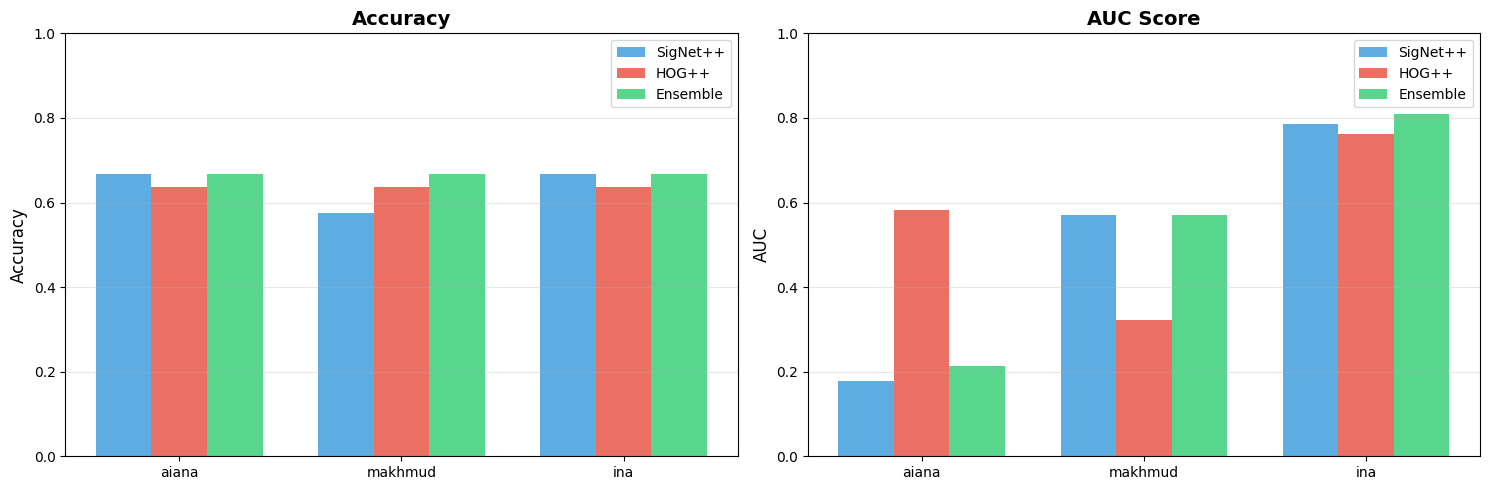

In [42]:
# Load your SigNet model
signet_model = SigNet()  # Your SigNet model
signet_model.load_state_dict(torch.load('sigver/models/signet.pth')[0])
signet_model.eval()

# Create evaluator
evaluator = ImprovedEvaluator(signet_model=signet_model)
# 
for person in ['aiana', 'makhmud', 'ina']:
    orig, fake = evaluator.load_images(f'sig_data/{person}', num_orig=7, num_fake=7)
    evaluator.run_experiment(person, orig, fake, num_train=3, num_seeds=3)

evaluator.plot_comparison()